<h1 style="background-color:#4E9A06; color:#ffffff; padding:10px 15px; border-radius:5px; margin-top:1rem; margin-bottom:1rem; text-align:center;">
  01 – ETL & Preprocessing
</h1>


<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Objectives
</h2>
 
This notebook performs Extract-Transform-Load (ETL) operations to prepare the merged climate-disease dataset for analysis:

- **Extract**: Load the merged inspection dataset from previous notebook
- **Transform**: 
  - Filter surveys to ≤6 months duration (Kirk et al. 2025 criterion)
  - Handle missing values via strategic dropping/imputation
  - Remove extreme climate outliers (2.5% quantile trim)
  - Engineer new features (anomalies, incidence zones)
- **Load**: Save a fully cleaned dataset for modeling

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Inputs
</h2>

**Merged Inspection Dataset** (`data/processed/merged_inspection.csv`):
- Combined plant disease survey and climate observations
- Contains identified data quality issues from inspection notebook
- Key variables:
  - Disease metrics: incidence, n_plants, n_infected
  - Climate measurements: temperature, precipitation (historical & contemporary)
  - Survey metadata: duration, location, taxonomy

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Outputs
</h2>

**Cleaned Analysis Dataset** (`data/processed/merged_climate_disease_final.csv`):
- Filtered to valid survey durations (≤6 months)
- Missing values handled according to strategy:
  - Drop: Extremely sparse columns (>90% missing)
  - Impute: Moderate missing using domain-appropriate methods
  - Preserve: Create "Unknown" categories for categorical variables
- Engineered features:
  - Temperature anomalies (z-scores from historical baseline)
  - Precipitation anomalies (percent deviation from normal)
  - Incidence zones (Low: 0-20%, Moderate: 20-50%, High: >50%)

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Additional Comments
</h2>

- **Data Quality Focus**: 
  - Rigorous outlier detection and handling
  - Imputation methods preserve data structure
  - All transformations documented for reproducibility
- **Validation Checks**:
  - Pre/post row counts for each operation
  - Missing value tracking
  - Distribution plots of key variables
- **Future Improvements**:
  - Automate validation checks
  - Add data quality metrics
  - Consider more sophisticated imputation methods
---

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
  1. Environment Setup & Imports
</h2>

In [5]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import os
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Add style_loader path manually
STYLE_DIR = Path.cwd() / "notebook_style"
if str(STYLE_DIR) not in sys.path:
    sys.path.insert(0, str(STYLE_DIR))

from style_loader import load_style

load_style()
print("Style loaded successfully")

Injected custom CSS from: c:\Users\baner\OneDrive\Documenti\data_analytics_AI\capstone_CI_main\climacrop_health\climacrop_health\jupyter_notebooks\notebook_style\custom.css
Style loaded successfully


<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
2. Change working directory
</h2>

In [6]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\baner\\OneDrive\\Documenti\\data_analytics_AI\\capstone_CI_main\\climacrop_health\\climacrop_health'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [7]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\baner\\OneDrive\\Documenti\\data_analytics_AI\\capstone_CI_main\\climacrop_health\\climacrop_health'

<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  1.1 Define File Paths
</h2>

In [9]:
# Define project root relative to notebook location
PROJECT_ROOT = Path.cwd()
RAW_DIR = PROJECT_ROOT / "data" / "raw"

# Point to specific files
SURVEY_PATH = RAW_DIR / "complete_plant_disease_database.csv"
CLIMATE_PATH = RAW_DIR / "complete_plant_study_climate_data.csv"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
INSPECT_FILE = PROCESSED_DIR / "merged_inspection.csv"

# Create the processed directory if it doesn’t exist
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)


print("Output will be saved to:", INSPECT_FILE)

Output will be saved to: c:\Users\baner\OneDrive\Documenti\data_analytics_AI\capstone_CI_main\climacrop_health\climacrop_health\data\processed\merged_inspection.csv


<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  1.2 Load Raw Data
</h2>

In [10]:
df = pd.read_csv(INSPECT_FILE)
print("Loaded shape:", df.shape)
df.head()

Loaded shape: (5906, 57)


,study_id,First_author,Study_Year,Person_extracting,Date_extracted,Paper_double_checked,study_reference,Host.species,Host_family,Host_order,...,annual_precip,end_date,monthly_precip,start_date,monthly_temp,contemp_temp,contemp_precip,.geo,calculated_incidence,duration_mo
0,715,Abbate,2014,Vianda,2021-06-30,Devin,Abbate_2014,Silene vulgaris,Caryophyllaceae,Caryophyllales,...,943.493736,2008-08-31,78.747861,2008-08-01,181.284576,288.956314,0.005280,"{""type"":""Polygon"",""coordinates"":[[[6.028999805...",0.000000,1
1,715,Abbate,2014,Vianda,2021-06-30,Devin,Abbate_2014,Silene vulgaris,Caryophyllaceae,Caryophyllales,...,1283.165287,2008-08-31,96.436140,2008-08-01,133.753340,288.499283,0.005288,"{""type"":""Polygon"",""coordinates"":[[[6.117000102...",0.000000,1
2,715,Abbate,2014,Vianda,2021-06-30,Devin,Abbate_2014,Silene vulgaris,Caryophyllaceae,Caryophyllales,...,1317.325816,2008-08-31,98.158494,2008-08-01,129.520853,288.499283,0.005288,"{""type"":""Polygon"",""coordinates"":[[[6.122000217...",0.000000,1
3,715,Abbate,2014,Vianda,2021-06-30,Devin,Abbate_2014,Silene vulgaris,Caryophyllaceae,Caryophyllales,...,1458.278376,2008-08-31,106.305506,2008-08-01,112.943493,288.128423,0.005225,"{""type"":""Polygon"",""coordinates"":[[[6.147999763...",0.027778,1
4,715,Abbate,2014,Vianda,2021-06-30,Devin,Abbate_2014,Silene vulgaris,Caryophyllaceae,Caryophyllales,...,898.312969,2008-08-31,77.168637,2008-08-01,189.015197,288.499283,0.005288,"{""type"":""Polygon"",""coordinates"":[[[6.083000183...",0.000000,1


<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  1.2 Filter surveys to ≤ 6 months
</h2>

<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 4: Blockquote explaining rationale                                    -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
> Enforces the paper’s survey length criterion, focusing on short-term climate effects.


In [11]:
# 1.2) Convert date column to datetime and filter duration
df["start_date"] = pd.to_datetime(df["start_date"], errors="coerce")
df["end_date"] = pd.to_datetime(df["end_date"], errors="coerce")
df["duration_mo"] = (
    (df.end_date.dt.year - df.start_date.dt.year) * 12
    + (df.end_date.dt.month - df.start_date.dt.month)
    + 1
)

# Inclusive month count:
df["duration_mo"] = (
    (df.end_date.dt.year - df.start_date.dt.year) * 12
    + (df.end_date.dt.month - df.start_date.dt.month)
    + 1
)

# Drop truly invalid rows:
invalid = df[
    df["duration_mo"].isna() | (df["duration_mo"] <= 0) | (df["duration_mo"] > 6)
]
df = df.drop(invalid.index).reset_index(drop=True)

# 3) Tally durations
counts = df["duration_mo"].value_counts().sort_index()
print("Survey counts by duration (months):")
print(counts)

# 4) Count invalids
too_short = (df["duration_mo"] <= 0).sum()
too_long = (df["duration_mo"] > 6).sum()
missing = df["duration_mo"].isna().sum()

print("\nInvalid buckets:")
print(f"  duration ≤ 0 : {too_short}")
print(f"  duration > 6 : {too_long}")
print(f"  missing      : {missing}")
print(f"\nTotal surveys : {len(df)}")


Survey counts by duration (months):
duration_mo
1    3822
2    1057
3     635
4     283
5     101
6       8
Name: count, dtype: int64

Invalid buckets:
  duration ≤ 0 : 0
  duration > 6 : 0
  missing      : 0

Total surveys : 5906



Missing value percentages:
Host.species                 0.7
Host_family                  0.4
Host_order                   0.4
Host_strain                 87.7
Host_type                    0.1
Host_age                    90.9
Water                       99.1
Antagonist_species           0.6
Antagonist_isolate          97.8
Transmission_mode           24.4
Vector_type                 43.7
Vector_species              47.7
Number_sampled_locations     3.2
Coarse_spatial_scale         1.4
annual_mean_temp             0.1
annual_precip                0.1
monthly_precip               8.9
monthly_temp                 8.9
contemp_temp                 0.7
contemp_precip               0.7
dtype: float64


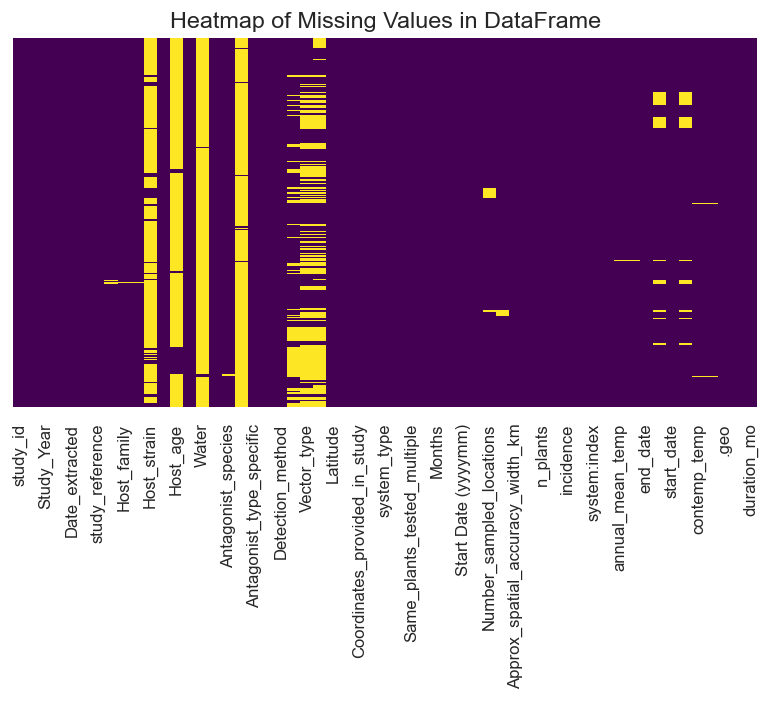

In [12]:
# 2. Percentage of missing values per column
missing_pct = (df.isnull().mean() * 100).round(1)
print("\nMissing value percentages:")
print(missing_pct[missing_pct > 0])

# 3. Visualize missingness heatmap (optional, but very insightful)
plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Heatmap of Missing Values in DataFrame")
plt.show()

In [13]:
df = df[df["duration_mo"] <= 6].reset_index(drop=True)
print("After duration filter:", df.shape)


After duration filter: (5906, 57)


> Enforces the paper’s survey length criterion, focusing on short-term climate effects.

<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  Summary Statistics & Missing Values
</h2>

First, we get a sense of distributions and confirm any remaining gaps.


In [14]:
# 2.1 Descriptive stats
display(df.describe())

# 2.2 Missing values
missing = df.isnull().sum().sort_values(ascending=False)
display(missing.head(10))


,Study_Year,Latitude,Longitude,Time_point,Start Date (yyyymm),Span (months),Number_sampled_locations,Approx_spatial_accuracy_width_km,n_plants,n_infected,...,annual_mean_temp,annual_precip,end_date,monthly_precip,start_date,monthly_temp,contemp_temp,contemp_precip,calculated_incidence,duration_mo
count,5906.000000,5906.000000,5906.000000,5906.000000,5906.000000,5906.000000,5716.000000,5906.000000,5906.000000,5906.000000,...,5903.000000,5903.000000,5906,5381.000000,5906,5381.000000,5863.000000,5.863000e+03,5904.000000,5906.000000
mean,2007.987470,20.896953,16.357306,0.758889,200384.428886,1.612936,7.563856,44.297663,517.379275,69.742162,...,160.204584,792.099124,2004-06-01 12:09:59.796816896,60.507659,2004-04-14 05:33:47.362004736,185.312652,292.045320,2.270181e-03,0.163814,1.612936
min,1990.000000,-45.907000,-123.170000,0.000000,198411.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,-3.949332,2.027794,1984-11-30 00:00:00,0.000000,1984-11-01 00:00:00,1.007726,266.991115,8.090000e-07,0.000000,1.000000
25%,2004.000000,7.122000,-5.547000,0.000000,200004.000000,1.000000,1.000000,3.000000,45.000000,0.000000,...,119.632702,404.431911,2000-04-30 00:00:00,20.203111,2000-04-01 00:00:00,148.085242,288.558860,3.660000e-04,0.000000,1.000000
50%,2008.000000,32.238000,35.730000,0.000000,200403.000000,1.000000,1.000000,10.000000,100.000000,2.000000,...,155.342208,752.418102,2004-03-31 00:00:00,47.237697,2004-03-01 00:00:00,181.939808,291.706569,1.566889e-03,0.020000,1.000000
75%,2013.000000,37.258000,49.244000,0.000000,200906.000000,2.000000,7.250000,50.000000,300.000000,27.000000,...,209.385012,1105.482213,2009-06-30 00:00:00,81.612267,2009-06-01 00:00:00,215.923891,295.392902,3.057303e-03,0.222222,2.000000
max,2021.000000,63.789000,172.963000,29.000000,201905.000000,6.000000,908.000000,500.000000,31200.000000,7631.000000,...,310.888808,3899.700752,2019-05-31 00:00:00,498.388140,2019-05-01 00:00:00,336.071854,306.630992,2.035292e-02,1.000000,6.000000
std,7.141145,25.411326,74.195122,2.541598,742.335914,0.986030,23.641118,68.818052,2192.917092,425.662637,...,63.979352,481.032453,NaN,57.429229,NaN,51.265798,5.239280,2.836458e-03,0.259993,0.986030


Water                       5851
Antagonist_isolate          5777
Host_age                    5368
Host_strain                 5181
Vector_species              2815
Vector_type                 2579
Transmission_mode           1442
monthly_precip               525
monthly_temp                 525
Number_sampled_locations     190
dtype: int64

<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  1.3 Quantile‐trim climate extremes (2.5%)
</h2>

In [15]:
# 1.3) Compute 2.5th and 97.5th percentiles for key climate vars and trim

for col in ["contemp_temp", "annual_mean_temp", "contemp_precip", "annual_precip"]:
    lo, hi = df[col].quantile([0.025, 0.975])
    df = df[(df[col] >= lo) & (df[col] <= hi)]
print("After quantile trim:", df.shape)


After quantile trim: (4934, 57)


<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 6: Blockquote with insight                                              -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
> **Insight:**  
> Trim the top and bottom 2.5% of daily temperature and precipitation to reduce outliers.


In [16]:
# Columns to summarize
cols = [
    "Water",
    "Antagonist_isolate",
    "Host_age",
    "Host_strain",
    "Vector_species",
    "Vector_type",
    "Transmission_mode",
    "Coarse_spatial_scale",
    "monthly_precip",
    "monthly_temp",
    "annual_mean_temp",
    "annual_precip",
    "contemp_temp",
    "contemp_precip",
]

# Build summary
summary = (
    (
        pd.DataFrame({"missing_count": df[cols].isnull().sum()}).assign(
            missing_pct=lambda d: (d["missing_count"] / len(df) * 100).round(1),
            data_type=lambda d: [
                "Categorical",
                "Categorical",
                "Numeric",
                "Categorical",
                "Categorical",
                "Categorical",
                "Categorical",
                "Categorical",
                "Numeric",
                "Numeric",
                "Numeric",
                "Numeric",
                "Numeric",
                "Numeric",
            ],
            imputation=lambda d: [
                "Drop (100% missing)",
                "Drop (99.6%)",
                "Drop (99.6%)",
                "Drop (95.3%)",
                "Fill 'Unknown'",
                "Fill 'Unknown'",
                "Fill mode",
                "Fill mode",
                "Median",
                "Median",
                "Median",
                "Median",
                "Median",
                "Median",
            ],
        )
    )
    .reset_index()
    .rename(columns={"index": "column"})
)

display(summary)

,column,missing_count,missing_pct,data_type,imputation
0,Water,4891,99.1,Categorical,Drop (100% missing)
1,Antagonist_isolate,4835,98.0,Categorical,Drop (99.6%)
2,Host_age,4416,89.5,Numeric,Drop (99.6%)
3,Host_strain,4452,90.2,Categorical,Drop (95.3%)
4,Vector_species,2290,46.4,Categorical,Fill 'Unknown'
5,Vector_type,2114,42.8,Categorical,Fill 'Unknown'
6,Transmission_mode,1230,24.9,Categorical,Fill mode
7,Coarse_spatial_scale,55,1.1,Categorical,Fill mode
8,monthly_precip,402,8.1,Numeric,Median
9,monthly_temp,402,8.1,Numeric,Median


<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 7: Section Header (H2) “1.4 Drop extremely sparse survey cols”       -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  1.4 Drop extremely sparse survey columns (&gt; 90% missing)
</h2>



<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 8: Blockquote with insight                                              -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
> **Insight:**  
> Columns with &gt;90% missing provide little information; drop them upfront.
> Columns: `Water`, `Antagonist_isolate`, `Host_age`, `Host_strain`

**Rationale:** Too little data to impute reliably; unlikely to drive climate–disease signal.

In [17]:
drop_cols = ["Water", "Antagonist_isolate", "Host_age", "Host_strain"]
df.drop(columns=drop_cols, errors="ignore", inplace=True)
print("After dropping sparse cols:", df.shape)


After dropping sparse cols: (4934, 53)


> **Insight:**  
> These metadata fields have little data and are unlikely to inform climate‐disease links.


<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 9: Section Header (H2) “1.5 Impute moderate‐missing categorical”    -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  1.5 Impute moderate‐missing categorical features (~12% missing)
</h2>


Columns: `Vector_species`, `Vector_type`

**Rationale:** Biological vectors matter; mark unknown rather than drop.

In [18]:
for col in ["Vector_species", "Vector_type"]:
    df[col].fillna("Unknown", inplace=True)

- Impute Low‐Missing Categorical Feature (~5%)

Column: `Transmission_mode`

**Rationale:** How pathogen spreads (air, water, contact) is useful–fill with mode.

In [19]:
df["Transmission_mode"].fillna(df["Transmission_mode"].mode()[0], inplace=True)

- Impute Very‐Low Missing Numeric Feature (~1.4%)

Column: `Coarse_spatial_scale`

**Rationale:** Spatial resolution matters; median preserves typical scale.

In [20]:
# Categorical imputation for Coarse_spatial_scale
df["Coarse_spatial_scale"].fillna(df["Coarse_spatial_scale"].mode()[0], inplace=True)

# Verify no more missing
df[["Vector_species", "Transmission_mode", "Coarse_spatial_scale"]].isnull().sum()


Vector_species          0
Transmission_mode       0
Coarse_spatial_scale    0
dtype: int64

<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 12: Section Header (H2) “1.6 Impute climate variables”                -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  1.6 Impute climate variables
</h2>
 
- **Median** for annual & contemporaneous  
- **KNN** for monthly historic  
 (~9%)

Columns: `monthly_temp`, `monthly_precip`

In [21]:
# Median for annual & contemporaneous
for col in ["annual_mean_temp", "annual_precip", "contemp_temp", "contemp_precip"]:
    df[col].fillna(df[col].median(), inplace=True)

# KNN for monthly
imputer = KNNImputer(n_neighbors=5)
df[["monthly_temp", "monthly_precip"]] = imputer.fit_transform(
    df[["monthly_temp", "monthly_precip"]]
)

print(
    "Missing after climate imputation:",
    df[["annual_mean_temp", "monthly_temp"]].isnull().sum(),
)


Missing after climate imputation: annual_mean_temp    0
monthly_temp        0
dtype: int64


We use KNN imputation for monthly values:
- preserves multivariate structure: KNN finds the k most similar observations (based on other climate features) and imputes missing values as their average, rather than a global median.

- respects seasonality: Monthly climate data often follow seasonal patterns; KNN can leverage similarity in months/locations rather than lumping all months together. 

- improves downstream modeling: More realistic imputation can yield better model performance than simple median fill when patterns are non‐uniform.

<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 13: Section Header (H2) “1.7 Drop rows with undefined incidence”     -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  1.7 Drop rows with undefined incidence
</h2>


In [22]:
undef = df[df["incidence"].isna() | (df["n_plants"] == 0)]
df.drop(index=undef.index, inplace=True)
print("After dropping undefined incidence:", df.shape)


After dropping undefined incidence: (4932, 53)


<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 14: Blockquote with insight                                             -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
> **Insight:**  
> Rows without a defined disease incidence code cannot be classified downstream.


<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 15: Section Header (H2) “1.8 Feature engineering: anomalies & zones” -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  1.8 Feature engineering: anomalies & incidence zones
</h2>


<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 16: Blockquote with insight                                             -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
> **Insight:**  
> Anomaly features capture deviation from long‐term norms; Incidence zones support classification and dashboard KPIs.


In [23]:
# Compute anomalies (H1–H3)
df["temp_anomaly"] = df["contemp_temp"] - df["monthly_temp"]
df["rain_anomaly"] = df["contemp_precip"] - df["monthly_precip"]

# Bin incidence into zones
df["incidence_zone"] = pd.cut(
    df["incidence"], bins=[-0.01, 0.2, 0.5, 1.0], labels=["Low", "Moderate", "High"]
)

print("Produced features: temp_anomaly, rain_anomaly, incidence_zone")


Produced features: temp_anomaly, rain_anomaly, incidence_zone


In [24]:
df[["temp_anomaly", "rain_anomaly"]].describe()

,temp_anomaly,rain_anomaly
count,4932.000000,4932.000000
mean,110.489659,-57.296553
std,36.116191,41.810259
min,2.977661,-329.821565
25%,87.705585,-74.863459
50%,111.602751,-52.998920
75%,136.994185,-27.221971
max,213.574535,0.000056


In [25]:
df["incidence_zone"].value_counts()

incidence_zone
Low         3735
Moderate     604
High         593
Name: count, dtype: int64

Missing value counts:
Host.species                42
Host_family                 24
Host_order                  24
Host_type                    1
Antagonist_species          36
Number_sampled_locations     9
dtype: int64

Missing value percentages:
Host.species                0.9
Host_family                 0.5
Host_order                  0.5
Antagonist_species          0.7
Number_sampled_locations    0.2
dtype: float64


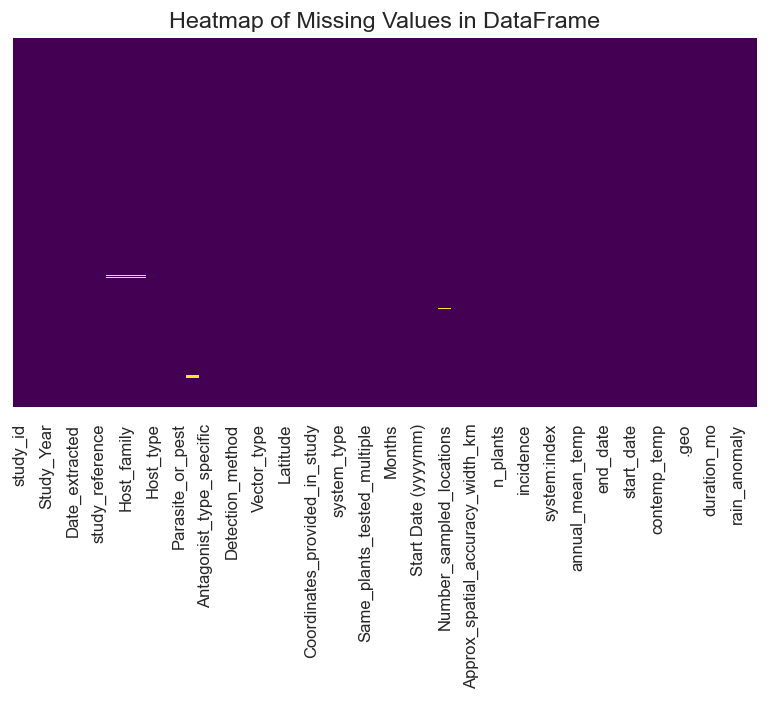

In [26]:
# 1. Count of missing values per column
missing_counts = df.isnull().sum()
print("Missing value counts:")
print(missing_counts[missing_counts > 0])

# 2. Percentage of missing values per column
missing_pct = (df.isnull().mean() * 100).round(1)
print("\nMissing value percentages:")
print(missing_pct[missing_pct > 0])

# 3. Visualize missingness heatmap (optional, but very insightful)
plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Heatmap of Missing Values in DataFrame")
plt.show()


In [27]:
# 4) Verify no missing values remain
remaining_missing = df.isnull().sum()
print("Remaining missing values per column:")
print(remaining_missing[remaining_missing > 0])

Remaining missing values per column:
Host.species                42
Host_family                 24
Host_order                  24
Host_type                    1
Antagonist_species          36
Number_sampled_locations     9
dtype: int64


Preserve the “missingness” signal, avoid dropping rows

In [29]:
df["Host_family"].fillna("Unknown", inplace=True)
df["Host_order"].fillna("Unknown", inplace=True)

In [30]:
df["Host_type"].fillna("Unknown", inplace=True)

Rare, but fill to keep rows

In [31]:
df["Antagonist_species"].fillna("Unknown", inplace=True)

Small %, median preserves typical scale

In [32]:
median_nloc = df["Number_sampled_locations"].median()
df["Number_sampled_locations"].fillna(median_nloc, inplace=True)

In [33]:
# 4) Verify no missing values remain
remaining_missing = df.isnull().sum()
print("Remaining missing values per column:")
print(remaining_missing[remaining_missing > 0])

Remaining missing values per column:
Host.species    42
dtype: int64


<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 17: Section Header (H2) “2. Save Cleaned Dataset”                    -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  2. Save Cleaned Dataset
</h2>


In [35]:
# — Write final cleaned dataset —
# out = "../data/processed/merged_climate_disease_final.csv"
# df.to_csv(out, index=False)
# print("Final cleaned dataset saved to:", df.shape)

cleaned_fp = PROCESSED_DIR / "merged_climate_disease_final.csv"
df.to_csv(cleaned_fp, index=False)
print(f"Saved cleaned dataset to: {cleaned_fp}", df.shape)


Saved cleaned dataset to: c:\Users\baner\OneDrive\Documenti\data_analytics_AI\capstone_CI_main\climacrop_health\climacrop_health\data\processed\merged_climate_disease_final.csv (4932, 56)


<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 18: Section Header (H2) “3. Conclusion & Next Steps”                -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  3. Conclusion & Next Steps
</h2>


- We have applied all ETL and preprocessing rules, including duration filtering, quantile‐trimming, and imputation.  
- Feature‐engineered anomalies (e.g., temperature z‐scores) and incidence zones are now available.  
- The fully cleaned and merged dataset is saved at `data/processed/cleaned_merged_data.csv`.  
- **Next:** Proceed to the “02_EDA” notebook to visualize distributions and relationships.  
